Why exactly is it helpful for an algorithm to be able to classify high-z sources from their spectra?
Ultimately science goal to use high-z to constrain cosmological parameters. How accurately we can constrain depends on . The better we can measure Ly-a the better the cosmological parameters. Increasing data volume. Finding high-z in an automated way, for HETDEX goals. 


# Questions 04/03/23:

    * Now that it's trained (after visually inspecting), how do I make this useful to other people?
    
    * After how many visual inspections can I feel confident everything is working as it should?
    

## Notes:
    * Get x and y for spectra plots
        - X axis should be wavelength in Angstroms and then the y-axis should be flux density a unit called f_Lambda and i believe the units ofr that are 10^-17 erg/s/cm^2/Angstrom

## Things to do:

    * Figure out important questions/notes for presentation
    
    * Visually inspect everything
    
## Presentation

    - They are interesting sources
    - Lyman Alpha cna be used to retrace reionzation, periond of unknown universe time. Can use lyman alpha to retrace back in time.
    - High redshift cause that is when reionization occurs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

In [2]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

In [3]:
# loading in the decoded sources I got from inputting random encoded sources into t-sne.
# These will be our testing sample
random_highz_sources = np.load("highz_sources.npy")

In [4]:
# loading in my high confidence high z sources.
high_confidence_highz_spectra_sn7 = np.load("high_confidence_highz_sn7_10000.npy", allow_pickle = True)
high_confidence_highz_spec_err_sn7 = np.load("high_confidence_highz_spec_err_sn7_10000.npy", allow_pickle = True)

In [5]:
# This code below takes my high-confidence high redshift sample and divides it by the high-confidence error. 
# Basically reduces the noisy parts and keeps the peaks (not perfect but really well).
# Returns the de-noised spectra into an array called 'high_confidence_over_specc_err'
num_sources = high_confidence_highz_spectra_sn7.shape[0]
confidence_over_spec_err_LS = [[0] * 1 for i in range(num_sources)]

counter = 0

while counter < num_sources:
    confidence_over_spec_err_LS[counter] = \
    high_confidence_highz_spectra_sn7[counter] / high_confidence_highz_spec_err_sn7[counter]
    
    counter += 1

high_confidence_over_specc_err = np.array(confidence_over_spec_err_LS)

In [6]:
# loading in the noise sample.
noise_sample = np.load("noise_sample_10000.npy", allow_pickle = True)

In [7]:
# combining my high-confidence spectra with my noise spectra into one large array
twodspectra = np.concatenate((high_confidence_over_specc_err, noise_sample))

In [8]:
# basically creating labels for my classification, a '1' is a high_z source and a '0' is a noise source
highz_classification = np.ones(10000)
noise_classification = np.zeros(10000)

merge_classification = np.append(highz_classification, noise_classification)

In [9]:
# setting my x and y to input into my ML algorithm
X = twodspectra
y = merge_classification

In [10]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [11]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

In [12]:
# creating a RF classifier
rfc = RandomForestClassifier(n_estimators = 700, random_state = 42)  

In [13]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=700, random_state=42)

In [14]:
# performing predictions on the test dataset
y_pred = rfc.predict(X_test)

In [15]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9855
Precision: 0.9819078947368421
Recall: 0.9893934371892609


In [17]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, normalize = 'true').ravel()

In [18]:
(tn, fp, fn, tp)

(0.9815621857190747,
 0.01843781428092524,
 0.010606562810739144,
 0.9893934371892609)

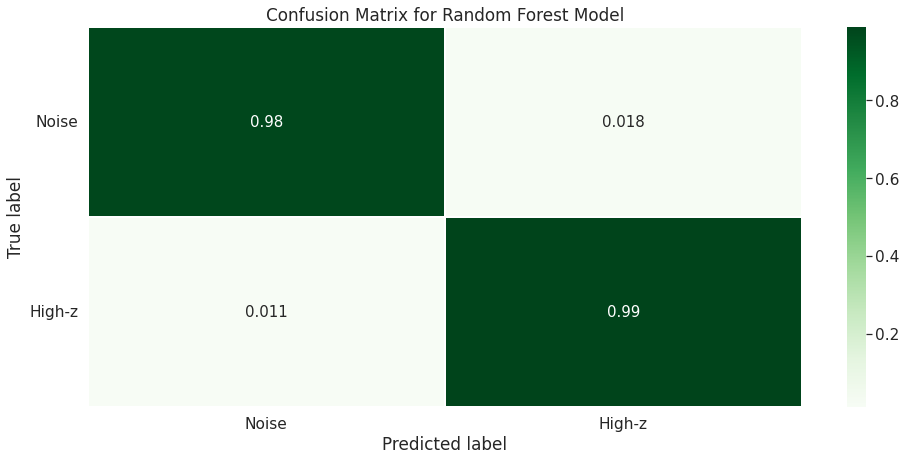

In [19]:
# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Noise', 'High-z']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names, rotation= 0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [20]:
false_positive = X_test[(y_test == 0) & (y_pred == 1)]  # predicted high-z but actually noise
false_negative = X_test[(y_test == 1) & (y_pred == 0)]  # predicted noise but actually high-z

true_positive = X_test[(y_test == 1) & (y_pred == 1)] # predicted high-z and actually is high-z
true_negative = X_test[(y_test == 0) & (y_pred == 0)] # predicted noise and actually is noise

In [27]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [28]:
# false_negative = predicted noise but actually high-z
# reminder: high_confidence_over_specc_err = high_confidence_highz_spectra_sn7 / high_confidence_highz_spec_err_sn7
def false_neg_check(n):
    # getting the index of where this false_neg is in the original array
    idx = np.where(high_confidence_over_specc_err == false_negative[n])[0][0]
    y = false_negative[n]
    y2 = high_confidence_highz_spectra_sn7[idx]
    y3 = high_confidence_highz_spec_err_sn7[idx]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 4));
    fig.suptitle("False negatives (predicted noise but actually high-z)", y = 1.05)
    ax1.plot(y)
    ax1.title.set_text("high-z/spec_err")
    ax2.plot(y2)
    ax2.title.set_text("high-z")
    ax3.plot(y3)
    ax3.title.set_text("spec_err")
    plt.show()
    
widgets.interact(false_neg_check, n=(0, false_negative.shape[0] - 1));

interactive(children=(IntSlider(value=15, description='n', max=31), Output()), _dom_classes=('widget-interact'…

In [29]:
# false_positive =  predicted high-z but actually noise
# for the noise, we never divided spec_err, so nothing to compare to, as in, with the high-z we can compare a
# before diving by spec_err and after
def false_pos_check(n):
    y = false_positive[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    fig.suptitle("False positives (predicted high-z but actually noise)", y = 1.05)
    ax.plot(y)
    plt.show()
    
widgets.interact(false_pos_check, n=(0, false_positive.shape[0] - 1));

interactive(children=(IntSlider(value=27, description='n', max=54), Output()), _dom_classes=('widget-interact'…

In [31]:
# true_negative = predicted noise and actually is noise
def true_neg_check(n):
    y = true_negative[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    fig.suptitle("True negative (predicted noise and actually is noise)", y = 1.05)
    ax.plot(y)
    plt.show()
    
widgets.interact(true_neg_check, n=(0, true_negative.shape[0] - 1));

interactive(children=(IntSlider(value=1463, description='n', max=2927), Output()), _dom_classes=('widget-inter…

In [32]:
# true_positive = predicted high-z and actually is high-z
# reminder: high_confidence_over_specc_err = high_confidence_highz_spectra_sn7 / high_confidence_highz_spec_err_sn7
def true_pos_check(n):
    # getting the index of where this false_neg is in the original array
    idx = np.where(high_confidence_over_specc_err == true_positive[n])[0][0]
    y = true_positive[n]
    y2 = high_confidence_highz_spectra_sn7[idx]
    y3 = high_confidence_highz_spec_err_sn7[idx]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 4));
    fig.suptitle("True positive (predicted high-z and actually is high-z)", y = 1.05)
    ax1.plot(y)
    ax1.title.set_text("high-z/spec_err")
    ax2.plot(y2)
    ax2.title.set_text("high-z")
    ax3.plot(y3)
    ax3.title.set_text("spec_err")
    plt.show()
    
widgets.interact(true_pos_check, n=(0, true_positive.shape[0] - 1));

interactive(children=(IntSlider(value=1492, description='n', max=2984), Output()), _dom_classes=('widget-inter…

# Ideas to try if our confidence stopped going up!

### Data set with sn > 7 and check if there's a difference to give us less false positives
### Warm start
### sklearn standard scaler (OR ANOTHER OPTION)
### cross correlation
### RandomParameterSearch
### Pass in the signal to noise spectrum (spec_err)

In [ ]:
from sklearn import tree
import dtreeviz # will be used for tree visualization

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(clf.estimators_[0], feature_names=X, filled=True)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(X, y)

In [ ]:
plt.figure(figsize=(18,18))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X, filled=True, fontsize = 10)

In [ ]:
viz = dtreeviz.model(rf.estimators_[0], X, y, feature_names=X, target_name="Target")

In [ ]:
viz.view() 

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0],
          class_names=["highz", "noise"], 
          filled=True, impurity=True, 
          rounded=True)

In [ ]:
plt.plot(X[42])

In [ ]:
plt.plot(X[984])

## Plotting
https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f 

https://builtin.com/data-science/random-forest-python-deep-dive

https://vitalflux.com/random-forest-classifier-python-code-example/

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/